In [ ]:
import pandas as pd
import torch
import string
import sys 
from collections import defaultdict
from torch import nn

def p(thing):
    sys.stdout.write(thing)


def isnan(x):
    if type(x) == str:
        return False
    try:
        int(x)
        return False
    except:
        return True


class pbar:
    def __init__(self, length, total, frac=False):
        self.length = length
        self.total = total
        if not frac:
            p('|' + '.' * length + '|')
        else:
            pass
        self.count = 0
        self.thresh = total // length
        self.all_count = 0
        self.n = 0

    def frac(self):
        if self.n == self.total - 1:
            p('\n')
            return
        if self.n > 0:
            p('\b' * self.len)
        string = f'{self.n}/{self.total}'
        p(string)
        self.len = len(string)
        self.n += 1


class fbar:
    def __init__(self, length):
        self.length = length - 1
        self.count = 0
        self.slen = 0

    def step(self):
        if self.count == self.length:
            p('\b' * self.slen)
            print(f'{self.count}/{self.length}')
            return
        p('\b' * self.slen)
        s = f'{self.count}/{self.length} '
        self.slen = len(s)
        p(s)
        self.count += 1


newsdf = pd.read_csv('./corona_fake.csv')
titles = newsdf['title']
text = newsdf['text']
labels = newsdf['label']
letters = string.ascii_letters + ' !0123456789?'


def enum1(x):
    for i in range(len(x)):
        yield (i + 1, x[i])


vocab = {letter: i for i, letter in enum1(letters)}
vocab = defaultdict(lambda: 0, vocab)
#print(vocab[''],vocab['7'])


def word2tensor(word):
    tens = [vocab[i] for i in word]
    if len(tens)>0:
      return torch.tensor(tens)
    else:
      return torch.tensor([0])


def stack(data):
    result = []
    for i in range(len(data)):
        try:
            result.append(word2tensor(data[i]))
        except:
            result.append(torch.zeros(1))
    return result


tensortext = stack(text)
tensorlabel = []
for label in labels:
    if label == 'Fake' or label == 'fake':
        tensorlabel.append(torch.zeros(1))
    elif label == 'TRUE':
        tensorlabel.append(torch.ones(1))
    else:
        # print(label,'n')
        tensorlabel.append(-1)
tensortitles = stack(titles)


def greatest_len(x):
    great = len(x[0])
    for i in x:
        if len(i) > great:
            great = i
        return great


def pad_to(x, length):
  if len(x)>=length:
    return x
  return torch.nn.functional.pad(x, (0, length - len(x)))


def clean(thing, length):
    new = []
    for sentence in thing:
        new.append(pad_to(sentence, length))
    return new


titlemax = 150
textmax = 400
ptext = clean(tensortext, textmax)
ptitle = clean(tensortitles, titlemax)
len(ptitle), len(ptext), len(tensorlabel)
all_data = []


def batcher(x, y, batch):
    c = batch
    re = []
    for i in range(0, len(x), batch):
        re.append((x[i:c], y[i:c]))
    return re


for j in range(len(ptitle)):
    if tensorlabel[j] < 0:
        # print(tensorlabel[j])
        pass
    elif sum(ptext[j]).sum() == 0 and sum(ptitle[j]).sum() == 0:
        pass
    else:
        all_data.append((ptitle[j], ptext[j], tensorlabel[j]))
train_data = all_data[264:]
val_data = all_data[:264]

def list2tensor(l):
  out=torch.empty(len(l),*l[0].shape)
  return torch.cat(l,out=out)
# print('done')
import math
split = 100
val_titles = list(titles)[:split]
val_text = list(text)[:split]
train_titles = list(titles)[split:]
train_labels = tensorlabel[split:]
train_text = list(text)[split:]
vali_labels=list(tensorlabel)[:split]
all_text=[(text[i],tensorlabel[i]) for i in range(len(text)) if not isnan(text[i]) and tensorlabel[i]>-1]
pro_train_text,pro_val_text=torch.utils.data.random_split(all_text,[len(all_text)-264,264])
with open('./stopwords.txt') as st:
  for i in st:
    stopwords=eval(i)
def remove_stops(x,tolist=False):
  if tolist:
    return list(filter(lambda x: x not in stopwords,x))
  else:
    return filter(lambda x: x not in stopwords,x)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_better(ob,trains,vals,epochs,optim='sgd',lr=0.01,loss='bce'):
  try:
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=ob().to(device)
    if loss=='bce':
      lossf=nn.BCELoss()
      fil_func=lambda x: x
    elif loss=='logs':
      lossf=nn.BCEWithLogitsLoss()
      fil_func=lambda x:torch.sigmoid(x)
    else:
      lossf=nn.MSELoss()
      fil_func=lambda x:x
    if optim=='sgd':
      o=torch.optim.SGD(model.parameters(),lr)
    elif optim=='adam':
      o=torch.optim.Adam(model.parameters(),lr)
    elif optim=='sadam':
      o=torch.optim.SparseAdam(model.parameters(),lr)
    losses=[float('inf'),float('inf'),float('inf')]
    valis=[float('inf'),float('inf'),float('inf')]
    for epoch in range(epochs):
      p=fbar(len(trains))
      for i,j in trains:
        p.step()
        pred=model(i)
        target=j.float().to(device)
        loss=lossf(pred.float(),target)
        model.zero_grad()
        o.zero_grad()
        loss.backward()
        o.step()
      model.eval()
      with torch.no_grad():
        count=0
        for vi,vt in vals:
          pred=model(vi)
          if torch.round(fil_func(pred))==vt.to(device):
              count+=1
      model.train()
      print(count/len(vals),f' epoch: {epoch}')
      print(loss)
      valis.append(count/len(vals))
      losses.append(loss)
      flat(losses,valis,o,lr)
    return model
  except KeyboardInterrupt:
    return model
def already_train_better(model,trains,vals,epochs,optim='sgd',lr=0.01,loss='bce',deflat=True):
  try:
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if loss=='bce':
      lossf=nn.BCELoss()
      fil_func=lambda x: x
    elif loss=='logs':
      lossf=nn.BCEWithLogitsLoss()
      fil_func=lambda x:torch.sigmoid(x)
    else:
      lossf=nn.MSELoss()
      fil_func=lambda x:x
    if optim=='sgd':
      o=torch.optim.SGD(model.parameters(),lr)
    elif optim=='adam':
      o=torch.optim.Adam(model.parameters(),lr)
    elif optim=='sadam':
      o=torch.optim.SparseAdam(model.parameters(),lr)
    losses=[float('inf'),float('inf'),float('inf')]
    valis=[float('inf'),float('inf'),float('inf')]
    for epoch in range(epochs):
      p=fbar(len(trains))
      for i,j in trains:
        p.step()
        pred=model(i)
        target=j.float().to(device)
        loss=lossf(pred.float(),target)
        model.zero_grad()
        o.zero_grad()
        loss.backward()
        o.step()
      model.eval()
      with torch.no_grad():
        count=0
        for vi,vt in vals:
          pred=model(vi)
          if torch.round(fil_func(pred))==vt.to(device):
              count+=1
      model.train()
      print(count/len(vals),f' epoch: {epoch}')
      print(loss)
      valis.append(count/len(vals))
      losses.append(loss)
      if deflat:
        flat(losses,valis,o,lr)
    return model
  except KeyboardInterrupt:
    return model

In [ ]:
class Thiccatten(nn.Module):
  def __init__(self,k,heads):
    super().__init__()
    self.qw=nn.Linear(k,k*heads)
    self.kw=nn.Linear(k,k*heads)
    self.vw=nn.Linear(k,k*heads)
    self.fc=nn.Linear(k*heads,k)
    self.heads=heads
  def forward(self,x):
    b,t,k=x.size()
    h=self.heads
    q=self.qw(x).view(b,t,h,k)
    key=self.kw(x).view(b,t,h,k)
    v=self.vw(x).view(b,t,h,k)
    keys = key.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = q.transpose(1, 2).contiguous().view(b * h, t, k)
    values = v.transpose(1, 2).contiguous().view(b * h, t, k)
    keys=keys/(k**0.25)
    queries=queries/(k**0.25)
    dot=torch.bmm(keys,queries.transpose(1,2))
    scaled_dot=torch.softmax(dot,dim=2)
    out = torch.bmm(scaled_dot, values).view(b, h, t, k)
    out=out.transpose(1,2).contiguous().view(b,t,k*h)
    return self.fc(out)

class tblock(nn.Module):
  def __init__(self, k, heads):
    super().__init__()

    self.attention = Thiccatten(k, heads=heads)

    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.ff = nn.Sequential(
      nn.Linear(k, 4 * k),
      nn.ReLU(),
      nn.Linear(4 * k, k))

  def forward(self, x):
    attended = self.attention(x)
    x = self.norm1(attended + x)
    
    fedforward = self.ff(x)
    return self.norm2(fedforward + x)

class c_transformer(nn.Module):
  def __init__(self,heads=8,depth=7,word_embed=20,max_seq=6000,mode='mean'):
    super().__init__()
    self.transformers=nn.Sequential(*[tblock(word_embed,heads) for i in range(depth)])
    self.w_embed=nn.EmbeddingBag(len(vocab)+1,word_embed,mode=mode)
    self.pos_embed=nn.Embedding(max_seq+1,word_embed)
    self.fc=nn.Linear(word_embed,1)
  def forward(self,x):
    w=torch.stack([self.w_embed(word2tensor(i).unsqueeze(0)) for i in remove_stops(x.split(' '))]).transpose(0,1).to(device)
    b,t,k=w.size()
    try:
      pos_embeddings=self.pos_embed(torch.arange(t)).expand(b,t,k)
    except:
      print(w.size(),x)
    attended=self.transformers(pos_embeddings+w)
    classes=self.fc(attended).mean(dim=1)
    return torch.sigmoid(classes.reshape(-1))
f=0
for i,j in pro_val_text:
  if j==0:
    f+=1
print(f/len(pro_val_text))
#hp3=train_better(c_transformer,pro_train_text,pro_val_text,25,lr=2.7e-6,optim='adam',loss='bce')

0.5454545454545454


In [ ]:
import signal
def s_input(opt,go=True):
  if go:
    try:
          foo = raw_input()
          opt.param_groups[0]['lr']=float(foo)
    except:
          return opt.param_groups[0]['lr']
def within(x,y,s):
  return abs(x-y)<s
def flat(x,x2,opt,olr):
  if mean_deviation(x[-3:])<0.002 or mean_deviation(x2[-3:])<0.002:
    for i in opt.param_groups:
      i['lr']+=0.00002
  else:
    if opt.param_groups[0]['lr']!=olr and not within(opt.param_groups[0]['lr'],olr,0.000001):
      for param in opt.param_groups:
        param['lr']-=0.00001
    if opt.param_groups[0]['lr']<olr:
      for pa in opt.param_groups:
        pa['lr']=olr
  [print(par['lr']) for par in opt.param_groups]
class backup:
  import os
  def __init__(self,directory):
    self.fnames=[]
    self.count=0
    self.dir=directory
  def save(self,s):
    torch.save(s.state_dict(),self.dir+f'backup{count}')
    self.fnames.append(self.dir+f'backup{count}')
  def finish(self,index):
    for i,j in enumerate(self.fnames):
      if i==index:
        pass
      else:
        os.remove(self.fname)
    return self.fname[index]

def mean_deviation(x):
  mean=sum(x)/len(x)
  deviations=[abs(i-mean) for i in x]
  return sum(deviations)/len(deviations)

In [ ]:
new_hp=c_transformer()
new_hp.load_state_dict(hp3.state_dict())
hp4=already_train_better(new_hp,pro_train_text,pro_val_text,25,lr=2.7e-6,optim='adam',loss='bce')

0/886 1/886 2/886 3/886 4/886 5/886 6/886 7/886 8/886 9/886 10/886 11/886 12/886 13/886 14/886 15/886 16/886 17/886 18/886 19/886 20/886 21/886 22/886 23/886 24/886 25/886 26/886 27/886 28/886 29/886 30/886 31/886 32/886 33/886 34/886 35/886 36/886 37/886 38/886 39/886 40/886 41/886 42/886 43/886 44/886 45/886 46/886 47/886 48/886 49/886 50/886 51/886 52/886 53/886 54/886 55/886 56/886 57/886 58/886 59/886 60/886 61/886 62/886 63/886 64/886 65/886 66/886 67/886 68/886 69/886 70/886 71/886 72/886 

In [ ]:
hp5=c_transformer()
hp5.load_state_dict(hp4.state_dict())
hp6=already_train_better(hp5,pro_train_text,pro_val_text,25,lr=2.7e-6,optim='adam',loss='bce')

0/886 1/886 2/886 3/886 4/886 5/886 6/886 7/886 8/886 9/886 10/886 11/886 12/886 13/886 14/886 15/886 16/886 17/886 18/886 19/886 20/886 21/886 22/886 23/886 24/886 25/886 26/886 27/886 28/886 29/886 30/886 31/886 32/886 33/886 34/886 35/886 36/886 37/886 38/886 39/886 40/886 41/886 42/886 43/886 44/886 45/886 46/886 47/886 48/886 49/886 50/886 51/886 52/886 53/886 54/886 55/886 56/886 57/886 58/886 59/886 60/886 61/886 62/886 63/886 64/886 65/886 66/886 67/886 68/886 69/886 70/886 71/886 72/886 

In [ ]:
loaded=torch.load('/content/model_75v2')
hp5=already_train_better(loaded,pro_train_text,pro_val_text,25,lr=2.7e-6,optim='adam',loss='bce')

0/886 1/886 2/886 3/886 4/886 5/886 6/886 7/886 8/886 9/886 10/886 11/886 12/886 13/886 14/886 15/886 16/886 17/886 18/886 19/886 20/886 21/886 22/886 23/886 24/886 25/886 26/886 27/886 28/886 29/886 30/886 31/886 32/886 33/886 34/886 35/886 36/886 37/886 38/886 39/886 40/886 41/886 42/886 43/886 44/886 45/886 46/886 47/886 48/886 49/886 50/886 51/886 52/886 53/886 54/886 55/886 56/886 57/886 58/886 59/886 60/886 61/886 62/886 63/886 64/886 65/886 66/886 67/886 68/886 69/886 70/886 71/886 72/886 

In [ ]:
torch.save(hp5,'model79')
from google.colab import files
files.download('model79')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
hp6=torch.load('/content/model79')
hp7=already_train_better(hp6,pro_train_text,pro_val_text,25,lr=2.7e-6,optim='adam',loss='bce')

0/886 1/886 2/886 3/886 4/886 5/886 6/886 7/886 8/886 9/886 10/886 11/886 12/886 13/886 14/886 15/886 16/886 17/886 18/886 19/886 20/886 21/886 22/886 23/886 24/886 25/886 26/886 27/886 28/886 29/886 30/886 31/886 32/886 33/886 34/886 35/886 36/886 37/886 38/886 39/886 40/886 41/886 42/886 43/886 44/886 45/886 46/886 47/886 48/886 49/886 50/886 51/886 52/886 53/886 54/886 55/886 56/886 57/886 58/886 59/886 60/886 61/886 62/886 63/886 64/886 65/886 66/886 67/886 68/886 69/886 70/886 71/886 72/886 

In [ ]:
sum_inator=c_transformer(mode='mean')
already_train_better(sum_inator,all_text[264:],all_text[:264],25,lr=2.7e-6,optim='adam',loss='bce',deflat=False)

0/886 1/886 2/886 3/886 4/886 5/886 6/886 7/886 8/886 9/886 10/886 11/886 12/886 13/886 14/886 15/886 16/886 17/886 18/886 19/886 20/886 21/886 22/886 23/886 24/886 25/886 26/886 27/886 28/886 29/886 30/886 31/886 32/886 33/886 34/886 35/886 36/886 37/886 38/886 39/886 40/886 41/886 42/886 43/886 44/886 45/886 46/886 47/886 48/886 49/886 50/886 51/886 52/886 53/886 54/886 55/886 56/886 57/886 58/886 59/886 60/886 61/886 62/886 63/886 64/886 65/886 66/886 67/886 68/886 69/886 70/886 71/886 72/886 

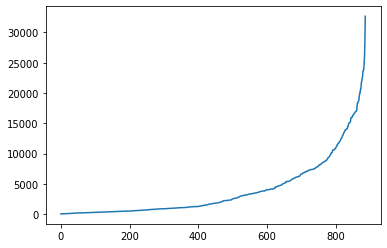

3966.5817361894024 3790.118376550169


In [ ]:
flen,tlen=[],[]
for i in range(len(pro_train_text)):
  flen.append(len(all_text[i][0]))
  tlen.append(len(pro_train_text[i][0]))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(sorted(flen))
#plt.plot(sorted(tlen))
plt.show()
print(sum(flen)/len(flen),sum(tlen)/len(tlen))